# VAE(Variational Auto Encoder)

### Import Lib

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

### Set hyperparams

In [ ]:
device = "cuda"
batch_size = 64
lr = 1e-03
epochs = 20

in_channels = 1
z_dim = 128
hidden_dim = 256

### Step 1. Define MNIST Dataset

In [ ]:
# image transform function
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root = ".", train = True, transform = transform, download = True)
test_dataset = MNIST(root = ".", train = False, transform = transform, download = True)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]


In [4]:
images, labels = next(iter(train_loader))

print("Images shape: {}".format(images.shape))
print("labels shape: {}".format(labels.shape))

Images shape: torch.Size([64, 1, 28, 28])
labels shape: torch.Size([64])


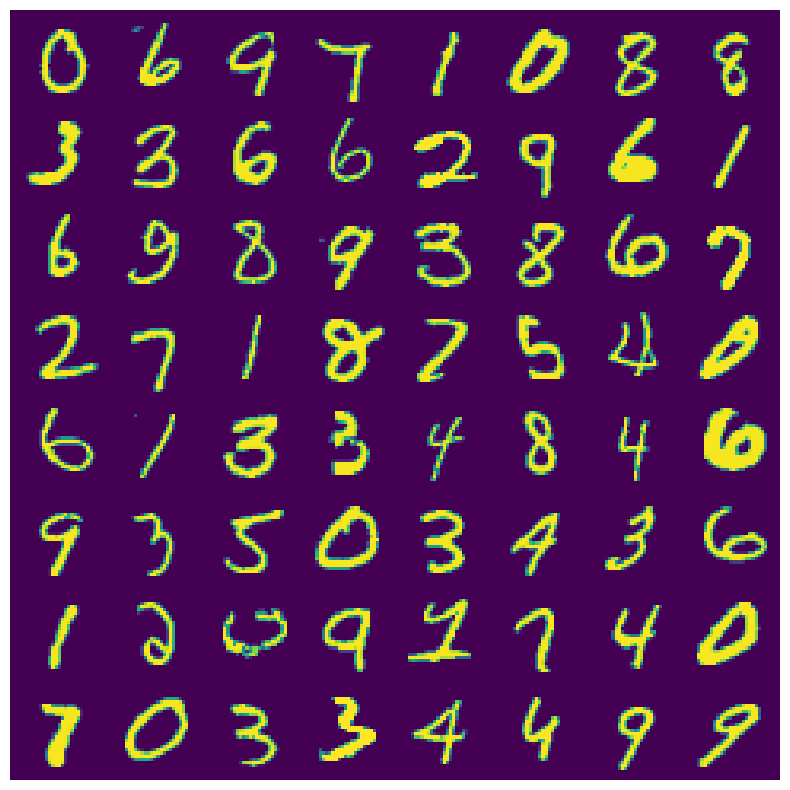

In [6]:
# Show images
def show_image(images, nrow=8, normalize=True, figsize = (8, 8), **kwargs):
    grid = make_grid(images, nrow=nrow, normalize=normalize, **kwargs)

    plt.figure(figsize=figsize)
    plt.imshow(grid[0])
    plt.axis("off")
    plt.tight_layout()
    plt.show()

show_image(images)

### Step 2. Define Variational AutoEncoder (VAE)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_dim=256):
        super().__init__()
        input_size = in_channels * 28 * 28 # C x H x W

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = self.flatten(x) # B x C x H x W -> B x CHW
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels=1, z_dim=128, hidden_dim=256):
        super().__init__()
        input_size = in_channels * 28 * 28 # C x H x W

        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x


class VAE(nn.Module):
    def __init__(self, in_channels=1, z_dim=128, hidden_dim=256):
        super().__init__()
        # Encoder
        self.encoder = Encoder(in_channels, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim, z_dim)
        # Decoder
        self.decoder = Decoder(in_channels, z_dim, hidden_dim)

    def reparameterize(self, mu, logvar):
        """
        z = mean + std dev. x noise;   noise ~ N(0,I)
        """
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(sigma).to(logvar.device)
        return mu + sigma * eps

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        out = self.decoder(z)
        out = out.view(-1, 1, 28, 28) # B x CHW -> B x C x H xW
        out = torch.sigmoid(out) # value to [0, 1]
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

### Step 3. Define Loss function & Model & Optimizer

In [ ]:
def loss_function(pred, target, mu, logvar):
    recon_loss = F.binary_cross_entropy(pred, target, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

model = VAE(in_channels=in_channels, z_dim=z_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, epoch, device):
    model.train()
    total = 0
    total_loss = 0.

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        total += data.size(0)

        optimizer.zero_grad()
        recon_data, mu, logvar = model(data)
        loss = criterion(recon_data, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"[Train] Epoch {epoch} [{total}/{len(dataloader.dataset)}]\tAvg Loss: {total_loss/total:.3f}")

    total_loss /= len(dataloader.dataset)
    return total_loss

@torch.no_grad()
def test_epoch(model, dataloader, criterion, epoch, device):
    model.eval()
    total = 0
    total_loss = 0.

    pbar = tqdm(dataloader, desc = f"[Test]  Epoch {epoch}")

    for data, _ in pbar:
        data = data.to(device)
        batch_size = data.size(0)

        recon_data, mu, logvar = model(data)
        loss = criterion(recon_data, data, mu, logvar)

        total_loss += loss.item()
        total += batch_size
        pbar.set_postfix(avg_loss=f"{total_loss/total:.3f}")

    total_loss /= len(dataloader.dataset)
    return total_loss

In [28]:
for epoch in range(1, epochs+1):
    _ = train_epoch(model, train_loader, loss_function, optimizer, epoch, device)
    _ = test_epoch(model, test_loader, loss_function, epoch, device)

[Train] Epoch 1 [64/60000]	Avg Loss: 543.461
[Train] Epoch 1 [6464/60000]	Avg Loss: 217.587
[Train] Epoch 1 [12864/60000]	Avg Loss: 207.088
[Train] Epoch 1 [19264/60000]	Avg Loss: 202.659
[Train] Epoch 1 [25664/60000]	Avg Loss: 198.591
[Train] Epoch 1 [32064/60000]	Avg Loss: 194.258
[Train] Epoch 1 [38464/60000]	Avg Loss: 190.064
[Train] Epoch 1 [44864/60000]	Avg Loss: 186.003
[Train] Epoch 1 [51264/60000]	Avg Loss: 182.289
[Train] Epoch 1 [57664/60000]	Avg Loss: 178.825


[Test]  Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 114.40it/s, avg_loss=149.216]


[Train] Epoch 2 [64/60000]	Avg Loss: 150.388
[Train] Epoch 2 [6464/60000]	Avg Loss: 147.305
[Train] Epoch 2 [12864/60000]	Avg Loss: 146.122
[Train] Epoch 2 [19264/60000]	Avg Loss: 144.572
[Train] Epoch 2 [25664/60000]	Avg Loss: 143.445
[Train] Epoch 2 [32064/60000]	Avg Loss: 142.188
[Train] Epoch 2 [38464/60000]	Avg Loss: 141.295
[Train] Epoch 2 [44864/60000]	Avg Loss: 140.507
[Train] Epoch 2 [51264/60000]	Avg Loss: 139.760
[Train] Epoch 2 [57664/60000]	Avg Loss: 139.174


[Test]  Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 113.87it/s, avg_loss=133.685]


[Train] Epoch 3 [64/60000]	Avg Loss: 138.805
[Train] Epoch 3 [6464/60000]	Avg Loss: 132.984
[Train] Epoch 3 [12864/60000]	Avg Loss: 132.450
[Train] Epoch 3 [19264/60000]	Avg Loss: 132.151
[Train] Epoch 3 [25664/60000]	Avg Loss: 131.831
[Train] Epoch 3 [32064/60000]	Avg Loss: 131.396
[Train] Epoch 3 [38464/60000]	Avg Loss: 130.911
[Train] Epoch 3 [44864/60000]	Avg Loss: 130.340
[Train] Epoch 3 [51264/60000]	Avg Loss: 130.026
[Train] Epoch 3 [57664/60000]	Avg Loss: 129.652


[Test]  Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 113.89it/s, avg_loss=125.308]


[Train] Epoch 4 [64/60000]	Avg Loss: 127.587
[Train] Epoch 4 [6464/60000]	Avg Loss: 124.691
[Train] Epoch 4 [12864/60000]	Avg Loss: 123.837
[Train] Epoch 4 [19264/60000]	Avg Loss: 123.888
[Train] Epoch 4 [25664/60000]	Avg Loss: 123.673
[Train] Epoch 4 [32064/60000]	Avg Loss: 123.530
[Train] Epoch 4 [38464/60000]	Avg Loss: 123.274
[Train] Epoch 4 [44864/60000]	Avg Loss: 123.196
[Train] Epoch 4 [51264/60000]	Avg Loss: 122.980
[Train] Epoch 4 [57664/60000]	Avg Loss: 122.720


[Test]  Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 114.18it/s, avg_loss=120.393]


[Train] Epoch 5 [64/60000]	Avg Loss: 116.602
[Train] Epoch 5 [6464/60000]	Avg Loss: 120.227
[Train] Epoch 5 [12864/60000]	Avg Loss: 120.246
[Train] Epoch 5 [19264/60000]	Avg Loss: 120.112
[Train] Epoch 5 [25664/60000]	Avg Loss: 120.099
[Train] Epoch 5 [32064/60000]	Avg Loss: 119.862
[Train] Epoch 5 [38464/60000]	Avg Loss: 119.730
[Train] Epoch 5 [44864/60000]	Avg Loss: 119.564
[Train] Epoch 5 [51264/60000]	Avg Loss: 119.415
[Train] Epoch 5 [57664/60000]	Avg Loss: 119.336


[Test]  Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 115.83it/s, avg_loss=118.428]


[Train] Epoch 6 [64/60000]	Avg Loss: 111.424
[Train] Epoch 6 [6464/60000]	Avg Loss: 117.139
[Train] Epoch 6 [12864/60000]	Avg Loss: 117.133
[Train] Epoch 6 [19264/60000]	Avg Loss: 117.382
[Train] Epoch 6 [25664/60000]	Avg Loss: 117.548
[Train] Epoch 6 [32064/60000]	Avg Loss: 117.434
[Train] Epoch 6 [38464/60000]	Avg Loss: 117.436
[Train] Epoch 6 [44864/60000]	Avg Loss: 117.421
[Train] Epoch 6 [51264/60000]	Avg Loss: 117.340
[Train] Epoch 6 [57664/60000]	Avg Loss: 117.218


[Test]  Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 116.76it/s, avg_loss=116.987]


[Train] Epoch 7 [64/60000]	Avg Loss: 119.220
[Train] Epoch 7 [6464/60000]	Avg Loss: 116.079
[Train] Epoch 7 [12864/60000]	Avg Loss: 116.012
[Train] Epoch 7 [19264/60000]	Avg Loss: 116.205
[Train] Epoch 7 [25664/60000]	Avg Loss: 116.073
[Train] Epoch 7 [32064/60000]	Avg Loss: 115.989
[Train] Epoch 7 [38464/60000]	Avg Loss: 115.965
[Train] Epoch 7 [44864/60000]	Avg Loss: 115.958
[Train] Epoch 7 [51264/60000]	Avg Loss: 115.791
[Train] Epoch 7 [57664/60000]	Avg Loss: 115.788


[Test]  Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 114.14it/s, avg_loss=115.969]


[Train] Epoch 8 [64/60000]	Avg Loss: 109.561
[Train] Epoch 8 [6464/60000]	Avg Loss: 115.163
[Train] Epoch 8 [12864/60000]	Avg Loss: 115.205
[Train] Epoch 8 [19264/60000]	Avg Loss: 114.707
[Train] Epoch 8 [25664/60000]	Avg Loss: 114.884
[Train] Epoch 8 [32064/60000]	Avg Loss: 114.652
[Train] Epoch 8 [38464/60000]	Avg Loss: 114.769
[Train] Epoch 8 [44864/60000]	Avg Loss: 114.771
[Train] Epoch 8 [51264/60000]	Avg Loss: 114.645
[Train] Epoch 8 [57664/60000]	Avg Loss: 114.621


[Test]  Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 113.67it/s, avg_loss=114.750]


[Train] Epoch 9 [64/60000]	Avg Loss: 118.051
[Train] Epoch 9 [6464/60000]	Avg Loss: 113.454
[Train] Epoch 9 [12864/60000]	Avg Loss: 113.382
[Train] Epoch 9 [19264/60000]	Avg Loss: 113.647
[Train] Epoch 9 [25664/60000]	Avg Loss: 113.612
[Train] Epoch 9 [32064/60000]	Avg Loss: 113.632
[Train] Epoch 9 [38464/60000]	Avg Loss: 113.614
[Train] Epoch 9 [44864/60000]	Avg Loss: 113.621
[Train] Epoch 9 [51264/60000]	Avg Loss: 113.589
[Train] Epoch 9 [57664/60000]	Avg Loss: 113.655


[Test]  Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 115.19it/s, avg_loss=114.083]


[Train] Epoch 10 [64/60000]	Avg Loss: 118.866
[Train] Epoch 10 [6464/60000]	Avg Loss: 112.756
[Train] Epoch 10 [12864/60000]	Avg Loss: 112.563
[Train] Epoch 10 [19264/60000]	Avg Loss: 112.613
[Train] Epoch 10 [25664/60000]	Avg Loss: 112.735
[Train] Epoch 10 [32064/60000]	Avg Loss: 112.804
[Train] Epoch 10 [38464/60000]	Avg Loss: 112.818
[Train] Epoch 10 [44864/60000]	Avg Loss: 112.841
[Train] Epoch 10 [51264/60000]	Avg Loss: 112.787
[Train] Epoch 10 [57664/60000]	Avg Loss: 112.796


[Test]  Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 111.37it/s, avg_loss=113.284]


[Train] Epoch 11 [64/60000]	Avg Loss: 114.807
[Train] Epoch 11 [6464/60000]	Avg Loss: 110.754
[Train] Epoch 11 [12864/60000]	Avg Loss: 111.534
[Train] Epoch 11 [19264/60000]	Avg Loss: 111.794
[Train] Epoch 11 [25664/60000]	Avg Loss: 111.850
[Train] Epoch 11 [32064/60000]	Avg Loss: 112.009
[Train] Epoch 11 [38464/60000]	Avg Loss: 112.011
[Train] Epoch 11 [44864/60000]	Avg Loss: 112.047
[Train] Epoch 11 [51264/60000]	Avg Loss: 112.079
[Train] Epoch 11 [57664/60000]	Avg Loss: 112.039


[Test]  Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 93.49it/s, avg_loss=112.510] 


[Train] Epoch 12 [64/60000]	Avg Loss: 102.285
[Train] Epoch 12 [6464/60000]	Avg Loss: 111.211
[Train] Epoch 12 [12864/60000]	Avg Loss: 111.299
[Train] Epoch 12 [19264/60000]	Avg Loss: 111.238
[Train] Epoch 12 [25664/60000]	Avg Loss: 111.304
[Train] Epoch 12 [32064/60000]	Avg Loss: 111.446
[Train] Epoch 12 [38464/60000]	Avg Loss: 111.459
[Train] Epoch 12 [44864/60000]	Avg Loss: 111.459
[Train] Epoch 12 [51264/60000]	Avg Loss: 111.461
[Train] Epoch 12 [57664/60000]	Avg Loss: 111.423


[Test]  Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 92.46it/s, avg_loss=112.302]


[Train] Epoch 13 [64/60000]	Avg Loss: 118.331
[Train] Epoch 13 [6464/60000]	Avg Loss: 110.849
[Train] Epoch 13 [12864/60000]	Avg Loss: 110.916
[Train] Epoch 13 [19264/60000]	Avg Loss: 110.991
[Train] Epoch 13 [25664/60000]	Avg Loss: 110.868
[Train] Epoch 13 [32064/60000]	Avg Loss: 110.800
[Train] Epoch 13 [38464/60000]	Avg Loss: 110.841
[Train] Epoch 13 [44864/60000]	Avg Loss: 110.954
[Train] Epoch 13 [51264/60000]	Avg Loss: 111.037
[Train] Epoch 13 [57664/60000]	Avg Loss: 111.033


[Test]  Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 104.24it/s, avg_loss=112.807]


[Train] Epoch 14 [64/60000]	Avg Loss: 105.585
[Train] Epoch 14 [6464/60000]	Avg Loss: 110.725
[Train] Epoch 14 [12864/60000]	Avg Loss: 110.626
[Train] Epoch 14 [19264/60000]	Avg Loss: 110.377
[Train] Epoch 14 [25664/60000]	Avg Loss: 110.475
[Train] Epoch 14 [32064/60000]	Avg Loss: 110.465
[Train] Epoch 14 [38464/60000]	Avg Loss: 110.514
[Train] Epoch 14 [44864/60000]	Avg Loss: 110.523
[Train] Epoch 14 [51264/60000]	Avg Loss: 110.501
[Train] Epoch 14 [57664/60000]	Avg Loss: 110.495


[Test]  Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 113.78it/s, avg_loss=111.979]


[Train] Epoch 15 [64/60000]	Avg Loss: 118.920
[Train] Epoch 15 [6464/60000]	Avg Loss: 109.541
[Train] Epoch 15 [12864/60000]	Avg Loss: 109.713
[Train] Epoch 15 [19264/60000]	Avg Loss: 109.819
[Train] Epoch 15 [25664/60000]	Avg Loss: 109.724
[Train] Epoch 15 [32064/60000]	Avg Loss: 109.842
[Train] Epoch 15 [38464/60000]	Avg Loss: 109.973
[Train] Epoch 15 [44864/60000]	Avg Loss: 109.923
[Train] Epoch 15 [51264/60000]	Avg Loss: 110.037
[Train] Epoch 15 [57664/60000]	Avg Loss: 110.083


[Test]  Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 114.46it/s, avg_loss=112.684]


[Train] Epoch 16 [64/60000]	Avg Loss: 112.354
[Train] Epoch 16 [6464/60000]	Avg Loss: 109.582
[Train] Epoch 16 [12864/60000]	Avg Loss: 109.402
[Train] Epoch 16 [19264/60000]	Avg Loss: 109.532
[Train] Epoch 16 [25664/60000]	Avg Loss: 109.599
[Train] Epoch 16 [32064/60000]	Avg Loss: 109.604
[Train] Epoch 16 [38464/60000]	Avg Loss: 109.587
[Train] Epoch 16 [44864/60000]	Avg Loss: 109.604
[Train] Epoch 16 [51264/60000]	Avg Loss: 109.556
[Train] Epoch 16 [57664/60000]	Avg Loss: 109.640


[Test]  Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 115.79it/s, avg_loss=110.832]


[Train] Epoch 17 [64/60000]	Avg Loss: 115.611
[Train] Epoch 17 [6464/60000]	Avg Loss: 108.468
[Train] Epoch 17 [12864/60000]	Avg Loss: 108.888
[Train] Epoch 17 [19264/60000]	Avg Loss: 108.943
[Train] Epoch 17 [25664/60000]	Avg Loss: 108.897
[Train] Epoch 17 [32064/60000]	Avg Loss: 108.814
[Train] Epoch 17 [38464/60000]	Avg Loss: 108.842
[Train] Epoch 17 [44864/60000]	Avg Loss: 108.827
[Train] Epoch 17 [51264/60000]	Avg Loss: 108.777
[Train] Epoch 17 [57664/60000]	Avg Loss: 108.815


[Test]  Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 113.68it/s, avg_loss=110.410]


[Train] Epoch 18 [64/60000]	Avg Loss: 108.036
[Train] Epoch 18 [6464/60000]	Avg Loss: 107.590
[Train] Epoch 18 [12864/60000]	Avg Loss: 108.034
[Train] Epoch 18 [19264/60000]	Avg Loss: 108.126
[Train] Epoch 18 [25664/60000]	Avg Loss: 108.234
[Train] Epoch 18 [32064/60000]	Avg Loss: 108.241
[Train] Epoch 18 [38464/60000]	Avg Loss: 108.416
[Train] Epoch 18 [44864/60000]	Avg Loss: 108.408
[Train] Epoch 18 [51264/60000]	Avg Loss: 108.362
[Train] Epoch 18 [57664/60000]	Avg Loss: 108.368


[Test]  Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 112.31it/s, avg_loss=110.287]


[Train] Epoch 19 [64/60000]	Avg Loss: 112.651
[Train] Epoch 19 [6464/60000]	Avg Loss: 108.000
[Train] Epoch 19 [12864/60000]	Avg Loss: 107.953
[Train] Epoch 19 [19264/60000]	Avg Loss: 108.218
[Train] Epoch 19 [25664/60000]	Avg Loss: 108.154
[Train] Epoch 19 [32064/60000]	Avg Loss: 108.092
[Train] Epoch 19 [38464/60000]	Avg Loss: 108.059
[Train] Epoch 19 [44864/60000]	Avg Loss: 108.103
[Train] Epoch 19 [51264/60000]	Avg Loss: 108.017
[Train] Epoch 19 [57664/60000]	Avg Loss: 108.000


[Test]  Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 113.94it/s, avg_loss=110.027]


[Train] Epoch 20 [64/60000]	Avg Loss: 114.228
[Train] Epoch 20 [6464/60000]	Avg Loss: 106.665
[Train] Epoch 20 [12864/60000]	Avg Loss: 107.227
[Train] Epoch 20 [19264/60000]	Avg Loss: 107.246
[Train] Epoch 20 [25664/60000]	Avg Loss: 107.296
[Train] Epoch 20 [32064/60000]	Avg Loss: 107.181
[Train] Epoch 20 [38464/60000]	Avg Loss: 107.401
[Train] Epoch 20 [44864/60000]	Avg Loss: 107.569
[Train] Epoch 20 [51264/60000]	Avg Loss: 107.590
[Train] Epoch 20 [57664/60000]	Avg Loss: 107.652


[Test]  Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 113.28it/s, avg_loss=109.671]


### Step 5. Generate images from test dataset

Reconstruction


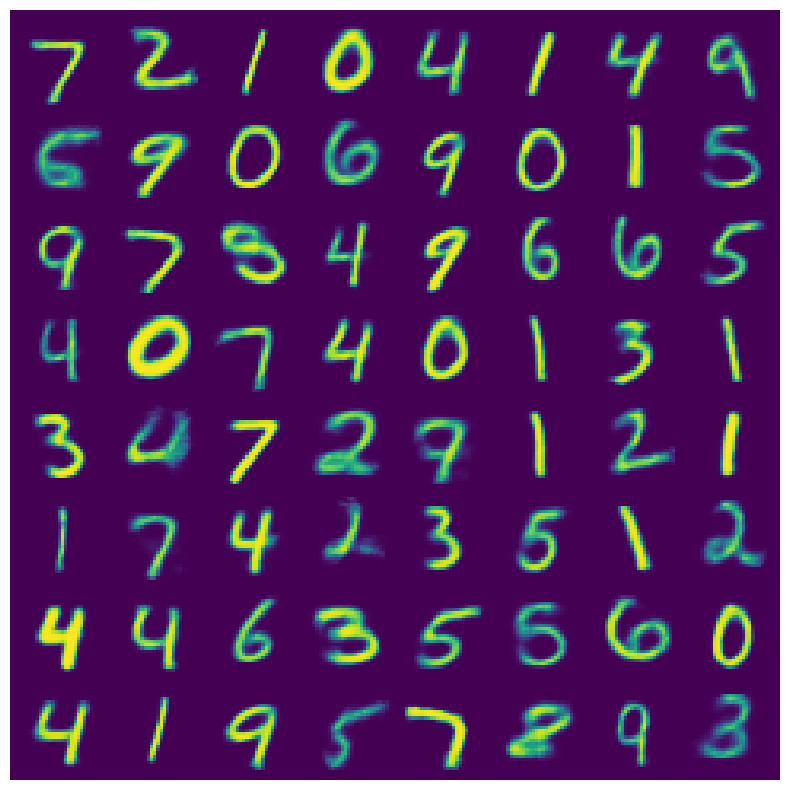

Ground Truth


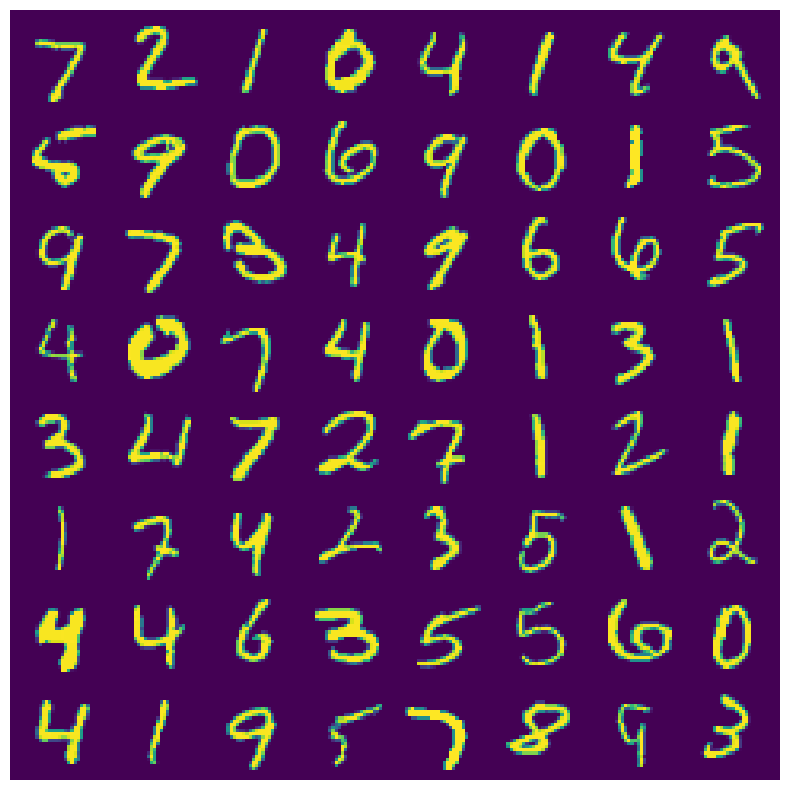

In [ ]:
images, label = next(iter(test_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    recon_images, _, _ = model(images)

print("Reconstruction")
show_image(recon_images.detach().cpu())

print("Ground Truth")
show_image(images.detach().cpu())

### Step 6. Generate image from noise vector

Generation Images from Random Noise


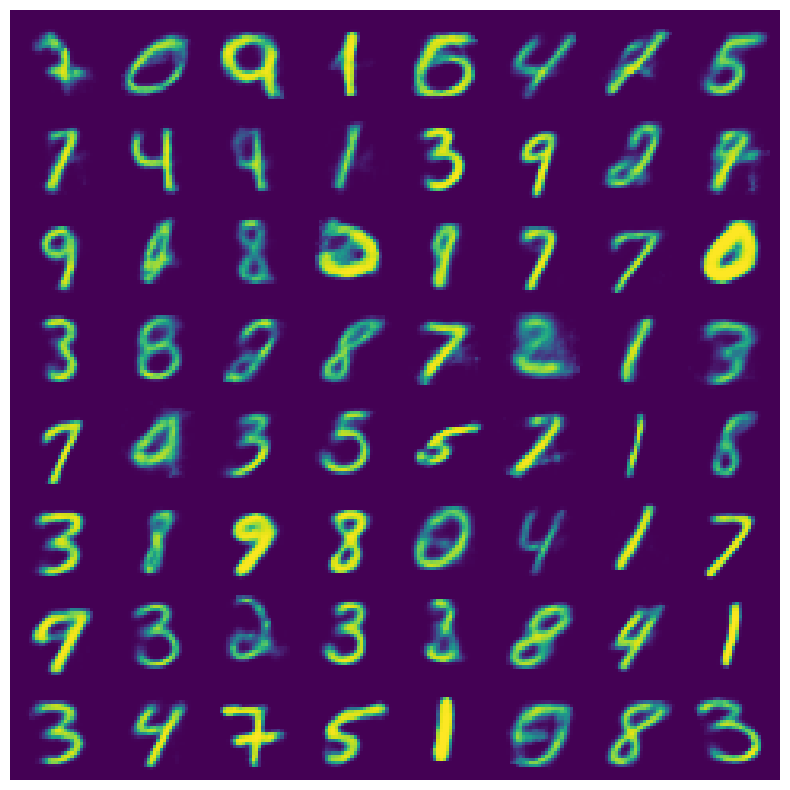

In [ ]:
model.eval()
with torch.no_grad():
    noise = torch.randn(batch_size, z_dim).to(device)
    generated_images = model.decode(noise)

print("Generation Images from Random Noise")
show_image(generated_images.detach().cpu())